In [1]:
import numpy as np
import pandas as pd
import scipy as sp

# from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris, load_digits


### Comparación de del humilde `EuclideanKDE` con implementaciones de referencia

In [2]:
mvn = sp.stats.multivariate_normal


class PicoKDE:
    """El estimador de densidad multivariada por núcleos más austero que pude."""

    def __init__(self, bandwidth=1):
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = np.array(
            [mvn(Xi, self.bandwidth**2 * np.eye(self.dim_)).pdf(X) for Xi in self.X_]
        ).mean(axis=0)

        return np.log(densities) if log else densities


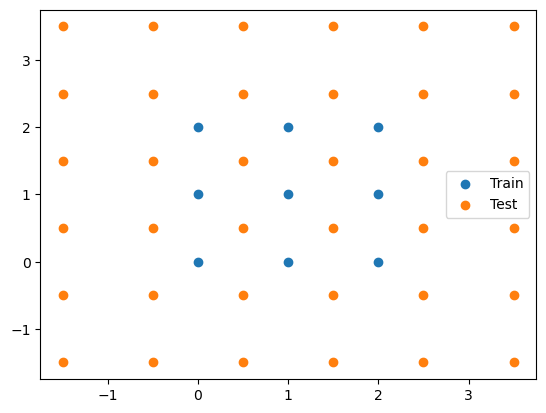

In [3]:
# Write a function `square_mesh` that returns a meshgrid of `dim` dimensions, with each dimension ranging from `a` to `b` with `step` increments
from itertools import product


def lattice(a, b, step=1, dim=2, array=True):
    side = np.arange(a, b, step)
    gen = product(*[side] * dim)
    return np.array([*gen]) if array else gen


a, b, step = 0, 3, 1
bw = 0.5
margin = step / 2 + 2 * bw
results = []
X_train = lattice(a, b, step, dim=2)
X_test = lattice(a - margin, b + margin, step, dim=2)


plt.scatter(X_train[:, 0], X_train[:, 1], label="Train")
plt.scatter(X_test[:, 0], X_test[:, 1], label="Test")
plt.legend()
plt.show()


In [4]:
pico_kde = PicoKDE(bandwidth=bw).fit(X_train)
pico_kde.density(X_test)

array([-11.64813647,  -7.63031591,  -6.94620855,  -6.94620855,
        -7.63031591, -11.64813647,  -7.63031591,  -3.61249536,
        -2.928388  ,  -2.928388  ,  -3.61249536,  -7.63031591,
        -6.94620855,  -2.928388  ,  -2.24428064,  -2.24428064,
        -2.928388  ,  -6.94620855,  -6.94620855,  -2.928388  ,
        -2.24428064,  -2.24428064,  -2.928388  ,  -6.94620855,
        -7.63031591,  -3.61249536,  -2.928388  ,  -2.928388  ,
        -3.61249536,  -7.63031591, -11.64813647,  -7.63031591,
        -6.94620855,  -6.94620855,  -7.63031591, -11.64813647])

In [5]:
from sklearn.neighbors import KernelDensity

scikit_kde = KernelDensity(bandwidth=bw).fit(X_train)
scikit_kde.score(X_test)


-210.05894957916462

In [6]:
def _score(self, X):
    return np.sum(self.density(X))


PicoKDE.score = _score


In [7]:
assert pico_kde.density(X_test).sum() == pico_kde.score(X_test)
pico_kde.score(X_test)


-210.05894957916462

In [8]:
%%timeit
PicoKDE().fit(X_train).density(X_test)

628 µs ± 46.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
%%timeit
KernelDensity(bandwidth=bw).fit(X_train).score_samples(X_test)

125 µs ± 8.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Square lattice

In [10]:
# Import the necessary methods to train a multivariete kernel density estimator using `statsmodels`, `scikit-learn` and `scipy`
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.stats import gaussian_kde

KDEMultivariate.predict = lambda self, X: np.log(self.pdf(X))
KernelDensity.predict = KernelDensity.score_samples
gaussian_kde.predict = lambda self, X: self.logpdf(X.T)
PicoKDE.predict = PicoKDE.density

a, b, step = 0, 1, 0.12
bw = 0.16
margin = step / 2 + 4 * bw
results = []
for dim in range(1, 4):
    X_train = lattice(a, b, step, dim)
    X_test = lattice(a - margin, b + margin, step, dim)
    print(dim, X_train.shape, X_test.shape, X_test[0])
    estimators = {
        "statsmodels": KDEMultivariate(data=X_train, var_type="c" * dim, bw=[bw] * dim),
        "scikit": KernelDensity(bandwidth=bw).fit(X_train),
        "scipy": gaussian_kde(X_train.T, bw_method=bw),
        "pico": PicoKDE(bandwidth=bw).fit(X_train),
    }
    log_dens = {k: est.predict(X_test).round(3) for k, est in estimators.items()}
    results.extend(
        {
            "dim": dim,
            "method": name,
            "p": sum(np.exp(logd) * (step**dim)),
            "logd": logd,
        }
        for name, logd in log_dens.items()
    )


1 (9, 1) (20, 1) [-0.7]
2 (81, 2) (400, 2) [-0.7 -0.7]
3 (729, 3) (8000, 3) [-0.7 -0.7 -0.7]


In [11]:
df = pd.DataFrame(results)


In [12]:
df[df.dim == 1]


dim       method        p  \
0    1  statsmodels  0.99998   
1    1       scikit  0.99998   
2    1        scipy  1.02223   
3    1         pico  0.99998   

                                                logd  
0  [-10.825, -7.804, -5.329, -3.387, -1.956, -0.9...  
1  [-10.825, -7.804, -5.329, -3.387, -1.956, -0.9...  
2  [-88.785, -61.007, -38.438, -21.076, -8.924, -...  
3  [-10.825, -7.804, -5.329, -3.387, -1.956, -0.9...

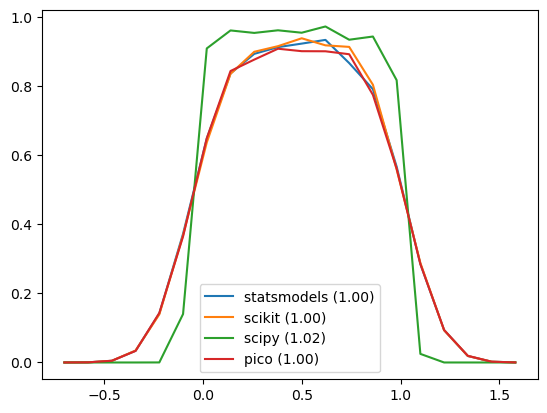

In [13]:
segment = lattice(a - margin, b + margin, step, dim=1).flatten()
noise = mvn(mean=np.ones_like(segment), cov=(0.05 / 3) ** 2 * np.eye(len(segment)))
noise.rvs()

for idx, row in df[df.dim == 1].iterrows():
    plt.plot(
        segment, np.exp(row.logd) * noise.rvs(), label=f"{row.method} ({row.p:.2f})"
    )
plt.legend()
plt.show()


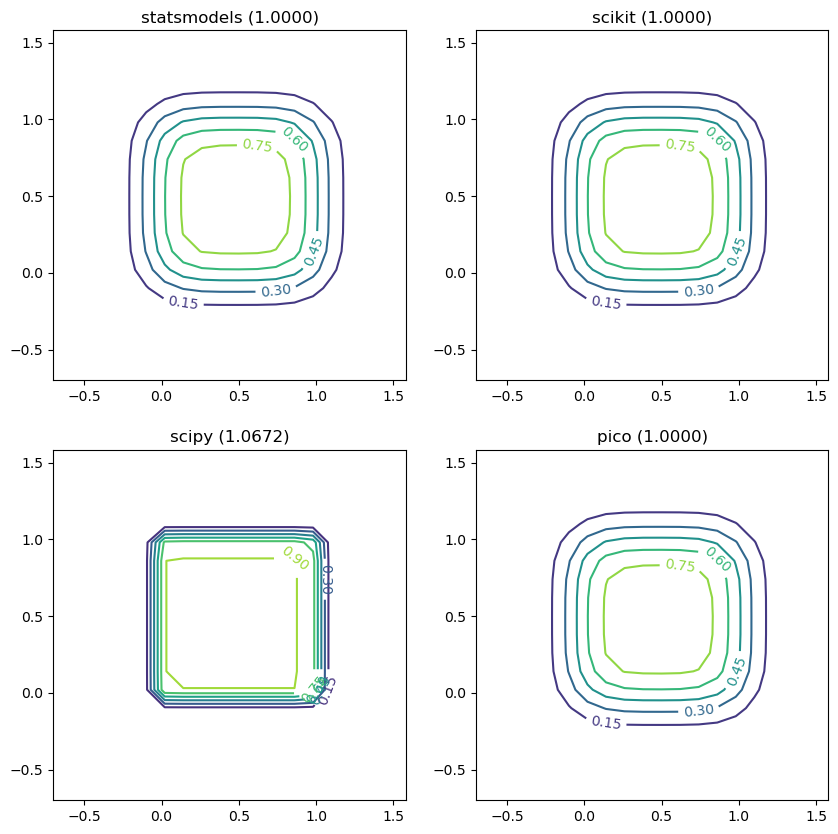

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in df[df.dim == 2].reset_index().iterrows():
    ax = axes[idx // 2, idx % 2]
    cs = ax.contour(segment, segment, np.exp(row.logd).reshape(npoints, npoints))
    ax.clabel(cs, inline=True)
    # ax.imshow(row.logd.reshape(npoints, npoints))
    ax.set_title(f"{row.method} ({row.p:.4f})")  # Add title to each panel
plt.show()


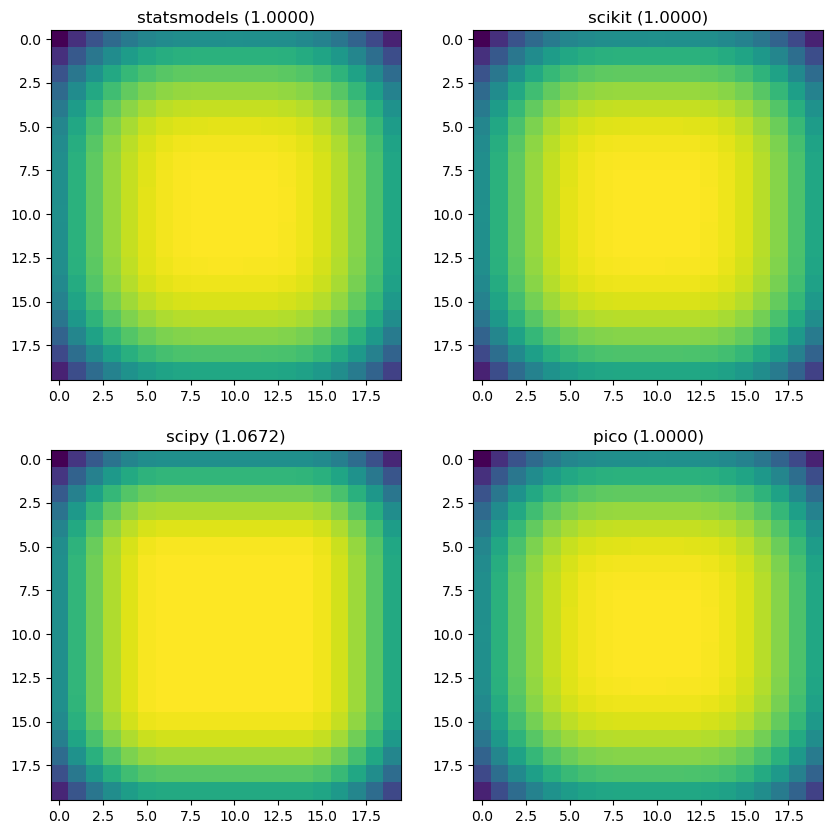

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in df[df.dim == 2].reset_index().iterrows():
    ax = axes[idx // 2, idx % 2]
    ax.imshow(row.logd.reshape(npoints, npoints))
    ax.set_title(f"{row.method} ({row.p:.4f})")  # Add title to each panel
plt.show()


In [16]:
ddd = df[df.dim == 3]
ddd.logd.apply(np.sum)


8     -65594.510
9     -65594.510
10   -508758.663
11    -65594.510
Name: logd, dtype: float64

In [17]:
ddd.logd.apply(lambda x: np.percentile(x, [0.05, 0.25, 0.5, 0.75, 0.9]).round(3))


8         [-29.455, -26.979, -25.038, -23.958, -23.551]
9         [-29.455, -26.979, -25.038, -23.958, -23.551]
10    [-267.798, -242.437, -222.932, -211.23, -207.329]
11        [-29.455, -26.979, -25.038, -23.958, -23.551]
Name: logd, dtype: object

In [18]:
X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only
n, dim = X.shape
bw = 0.2
iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
iris_results.extend(
    {
        "dim": dim,
        "method": name,
        "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


150 2 [5.1 3.5]


In [19]:
pd.DataFrame(iris_results)

dim       method         p  \
0    2  statsmodels  0.590936   
1    2       scikit  0.590936   
2    2        scipy  0.768084   
3    2         pico  0.590936   

                                                logd  
0  [-0.946, -1.365, -1.207, -1.424, -1.071, -1.87...  
1  [-0.946, -1.365, -1.207, -1.424, -1.071, -1.87...  
2  [-0.562, -0.936, -0.967, -1.096, -0.977, -1.66...  
3  [-0.946, -1.365, -1.207, -1.424, -1.071, -1.87...

In [20]:
xs = np.linspace(X[:, 0].min() * 0.95, X[:, 0].max() * 1.05, 30)
ys = np.linspace(X[:, 1].min() * 0.95, X[:, 1].max() * 1.05, 30)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


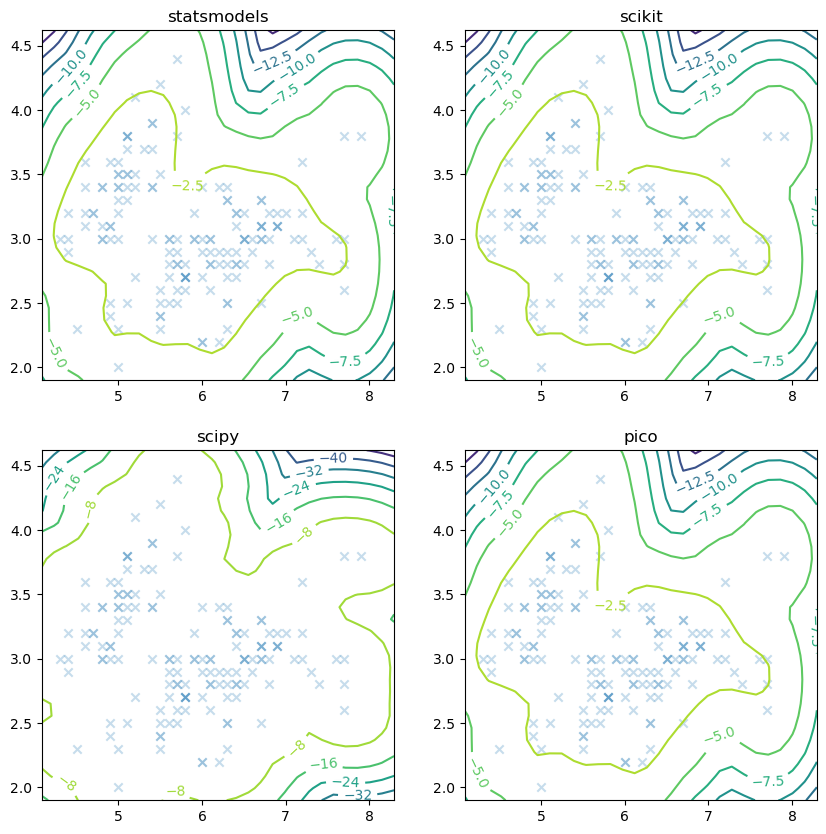

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(iris_results).iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(row.method)  # Add title to each panel
plt.show()


In [22]:
np.cov(X, rowvar=False)

array([[ 0.68569351, -0.042434  ],
       [-0.042434  ,  0.18997942]])

In [23]:
# Invert X's covariance matrix
X_cov_inv = np.linalg.inv(np.cov(X, rowvar=False))
X_cov_inv_sqrt = sp.linalg.sqrtm(X_cov_inv)

In [24]:
# Whiten data and redo
X @ X_cov_inv_sqrt.T
np.cov(X @ X_cov_inv_sqrt.T, rowvar=False).round(5)

array([[ 1., -0.],
       [-0.,  1.]])

In [25]:
X = X @ X_cov_inv_sqrt.T
xs = np.linspace(X[:, 0].min() * 0.95, X[:, 0].max() * 1.05, 30)
ys = np.linspace(X[:, 1].min() * 0.95, X[:, 1].max() * 1.05, 30)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


In [26]:
whitened_iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
whitened_iris_results.extend(
    {
        "dim": dim,
        "method": name,
        "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


150 2 [6.51181305 8.55785644]


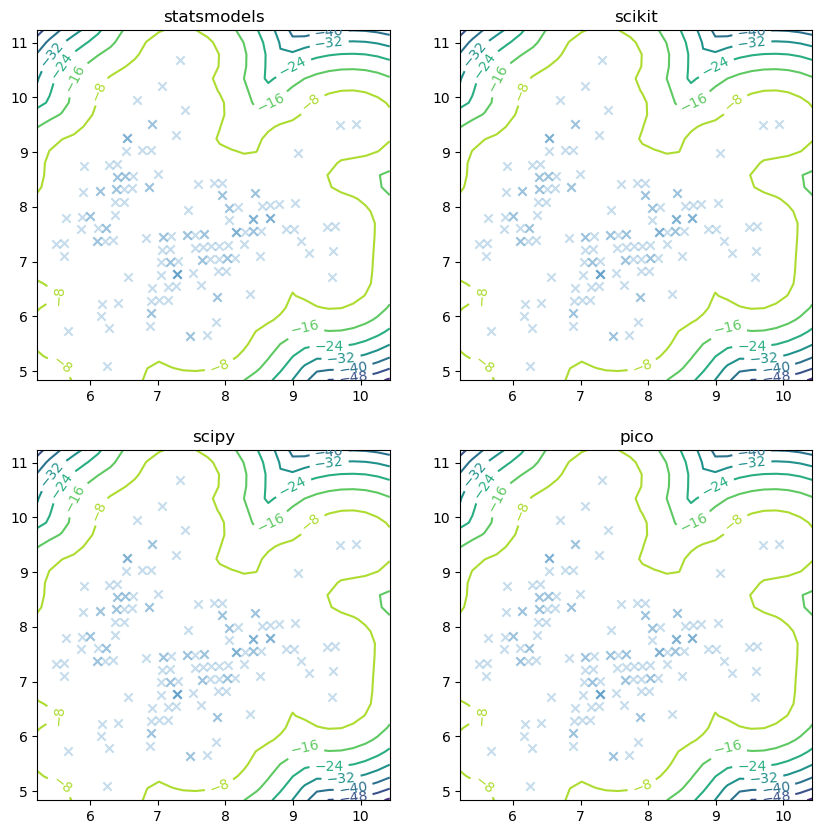

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(whitened_iris_results).iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(row.method)  # Add title to each panel
plt.show()


In [28]:
pd.DataFrame(whitened_iris_results).set_index("method").logd.apply(np.sum)

method
statsmodels   -332.276
scikit        -332.276
scipy         -332.276
pico          -332.276
Name: logd, dtype: float64

## FermatKDE

In [29]:
# X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only

In [30]:
# Import distance_matrix and pairwise distances
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances, euclidean_distances

In [31]:
# X = mvn(mean=[0] * 20).rvs(size=10000)
X = lattice(0, 5, 1, dim=3)

In [32]:
assert np.all(squareform(pdist(X, metric="euclidean")) == distance_matrix(X, X, p=2))


In [33]:
%%timeit
pdist(X, metric="euclidean")

12.3 µs ± 738 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [34]:
%%timeit
squareform(pdist(X, metric="euclidean"))

19.4 µs ± 102 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [35]:
%%timeit
distance_matrix(X, X, p=2)

436 µs ± 91.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [36]:
%%timeit
pairwise_distances(X, metric="euclidean")

156 µs ± 24.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
%%timeit
euclidean_distances(X)

143 µs ± 33.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Vamos con `pdist` que es consistentemente la mejorcita

In [38]:
def euclidean(X, Y=None):
    if Y is None:
        return squareform(pdist(X, metric="euclidean"))
    else:
        return cdist(X, Y, metric="euclidean")
    

def power_euclidean(X, Y=None, p=2):
    _euclidean = euclidean(X, Y)
    return _euclidean ** p

def scalar_euclidean(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [39]:
class FermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def density(self, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self.fermat_dists_ / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities


In [40]:
# X = lattice(0, 3, 1, dim=2)
X = load_iris(return_X_y=True)[0][:, :2]
# X = mvn(mean=[0] * 20).rvs(size=10000)
X.shape

(150, 2)

In [41]:
%%timeit
FermatKDE(alpha=1, bandwidth=1).fit(X)

4.59 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%%timeit
PicoKDE(bandwidth=1).fit(X)

304 ns ± 41.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [43]:
%%timeit
FermatKDE(alpha=1, bandwidth=1).fit(X).density()

4.73 ms ± 691 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
%%timeit
PicoKDE(bandwidth=1).fit(X).density(X)

10.4 ms ± 493 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
fermat = FermatKDE(alpha=1, bandwidth=1).fit(X)
f_dens = fermat.density()
e_dens = PicoKDE(bandwidth=1).fit(X).density(X)

In [46]:
f_dens[:10], e_dens[:10]

(array([-2.41736601, -2.43784423, -2.55432314, -2.61745831, -2.49513802,
        -2.54467573, -2.65192713, -2.4274705 , -2.79123712, -2.43492391]),
 array([-2.41713038, -2.43784423, -2.55405294, -2.61745831, -2.49513802,
        -2.54363707, -2.65192713, -2.42723248, -2.79123712, -2.43468411]))

In [47]:
FermatKDE.predict = lambda self, X: self.density()  # Parche

# X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only
# # `Fermat` no lidia bien con distancias entre puntos repetidos
# # Add random gaussian noise to X to avoid issues with repeated points
# X += np.random.normal(0, 0.0001, size=X.shape)
# Import make_moons
from sklearn.datasets import make_moons
X = make_moons(n_samples=1000, noise=0.1)[0]

n, dim = X.shape
bw = 0.27
iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
    "Fermat (alpha=1)": FermatKDE(alpha=1, bandwidth=bw).fit(X),
    "Fermat (alpha=1.25)": FermatKDE(alpha=1.25, bandwidth=bw).fit(X),
    "Fermat (alpha=1.5)": FermatKDE(alpha=1.5, bandwidth=bw).fit(X),
    "Fermat (alpha=2)": FermatKDE(alpha=2, bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
iris_results.extend(
    {
        "dim": dim,
        "method": name,
        "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


1000 2 [0.6527097  0.83816812]


In [48]:
(
    PicoKDE(bandwidth=2).fit(X).density(X).round(3)[:10],
    FermatKDE(alpha=1, bandwidth=2).fit(X).density().round(3)[:10],
)


(array([-3.39 , -3.385, -3.407, -3.382, -3.506, -3.367, -3.526, -3.473,
        -3.423, -3.568]),
 array([-3.39 , -3.385, -3.407, -3.382, -3.506, -3.367, -3.526, -3.473,
        -3.423, -3.568]))

In [49]:
a = FermatKDE(alpha=1, bandwidth=2).fit(X)

In [50]:
assert np.allclose(a.fermat_dists_, a.euclidean_dists_)

In [51]:
diffx, diffy = np.where(~np.isclose(a.fermat_dists_, a.euclidean_dists_))


In [52]:
np.vstack([diffx, diffy]).T[:5]

array([], shape=(0, 2), dtype=int64)

In [53]:
a.fermat_dists_[0, 17], a.euclidean_dists_[0, 17]

(1.819162779120971, 1.819162779120971)

In [54]:
a.X_[0], a.X_[17]

(array([0.6527097 , 0.83816812]), array([-1.05425204,  0.20917303]))

In [55]:
# xs = np.linspace(X[:, 0].min() * 0.95, X[:, 0].max() * 1.05, 30)
# ys = np.linspace(X[:, 1].min() * 0.95, X[:, 1].max() * 1.05, 30)
# xx, yy = np.meshgrid(xs, ys)
# X_test = np.array(list(zip(xx.ravel(), yy.ravel())))
xx = X[:, 0]
yy = X[:, 1]
# xx.shape, yy.shape, estimators["Fermat (alpha=1.25)"].predict(X).shape

In [56]:
pd.DataFrame(iris_results)

dim               method          p  \
0    2          statsmodels   2.932845   
1    2               scikit   2.932845   
2    2                scipy   3.900606   
3    2                 pico   2.932845   
4    2     Fermat (alpha=1)   2.932845   
5    2  Fermat (alpha=1.25)   6.544293   
6    2   Fermat (alpha=1.5)  14.218032   
7    2     Fermat (alpha=2)  29.096168   

                                                logd  
0  [-1.572, -1.384, -1.458, -1.781, -1.568, -1.64...  
1  [-1.572, -1.384, -1.458, -1.781, -1.568, -1.64...  
2  [-1.11, -0.944, -0.962, -1.5, -1.28, -1.407, -...  
3  [-1.572, -1.384, -1.458, -1.781, -1.568, -1.64...  
4  [-1.572, -1.384, -1.458, -1.781, -1.568, -1.64...  
5  [-0.75, -0.567, -0.625, -0.836, -0.777, -0.713...  
6  [0.103, 0.15, 0.13, 0.067, -0.042, 0.126, -0.3...  
7  [0.73, 0.726, 0.724, 0.726, 0.697, 0.731, 0.65...

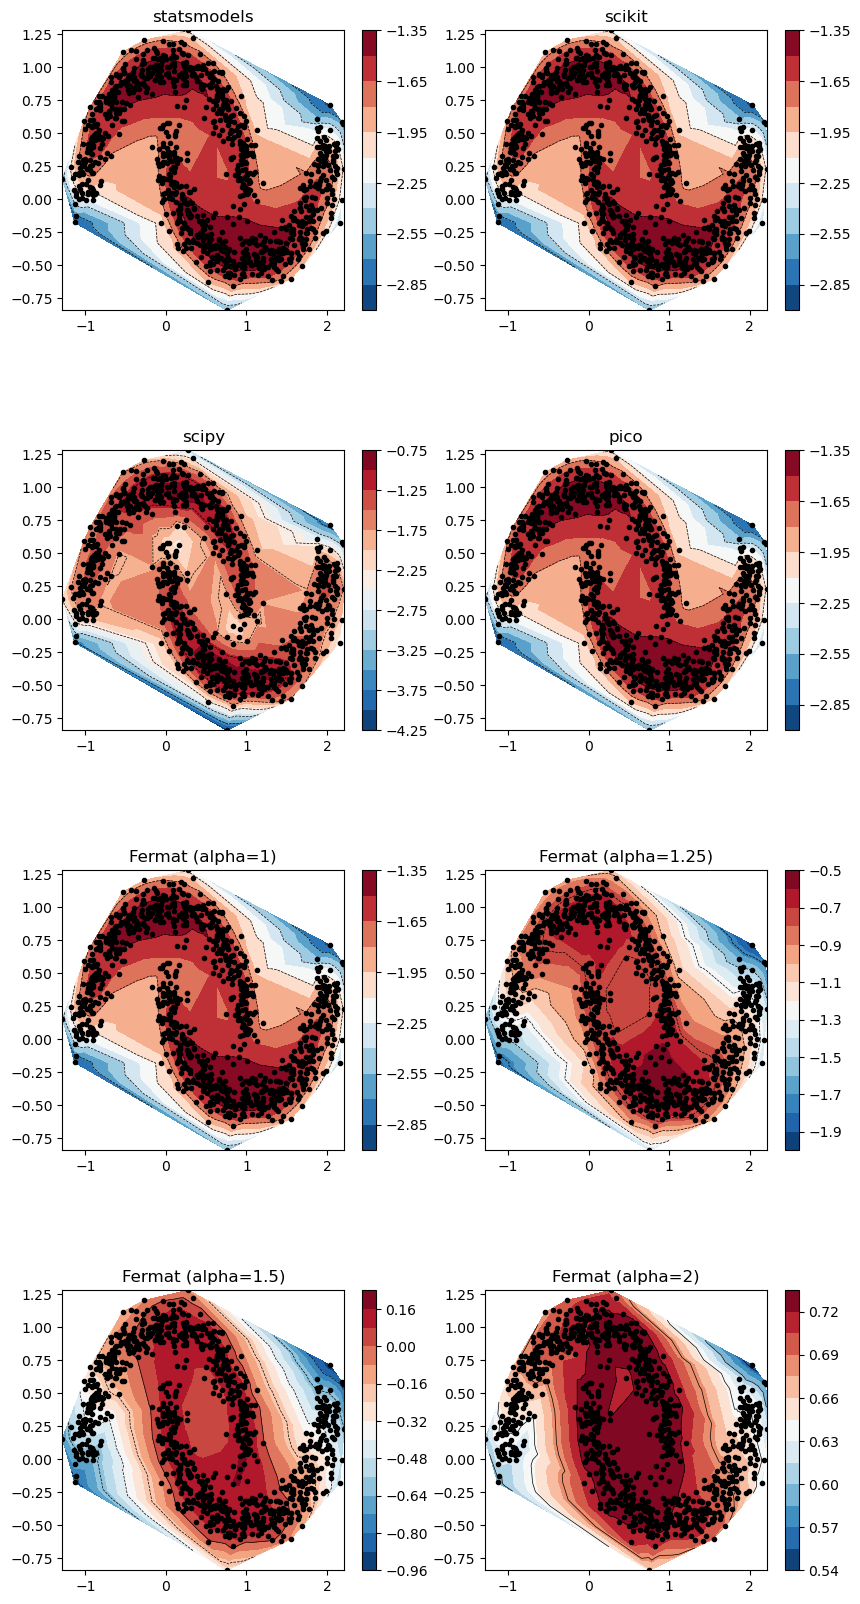

In [57]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(iris_results).iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X)
    # cs = ax.contour(xx, yy, zz)
    # ax.clabel(cs, inline=True)
    # ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    # ax.set_title(row.method)  # Add title to each panel
    
    ax.tricontour(xx, yy, zz, levels=5, linewidths=0.5, colors='k')
    cntr = ax.tricontourf(xx, yy, zz, levels=14, cmap="RdBu_r")

    fig.colorbar(cntr, ax=ax)
    ax.plot(xx, yy, 'ko', ms=3)
    # ax.set(xlim=(-2, 2), ylim=(-2, 2))
    ax.set_title(row.method)

plt.subplots_adjust(hspace=0.5)
plt.show()


In [58]:
class OOSFermatKDE:
    def __init__(self, alpha=1, bandwidth=1):
        self.alpha = alpha
        self.bandwidth = bandwidth

    def fit(self, X):
        self.X_ = X
        self.euclidean_dists_ = euclidean(X)
        self.fermat_ = Fermat(alpha=self.alpha, path_method="FW").fit(
            self.euclidean_dists_
        )
        self.fermat_dists_ = self.fermat_.get_distances()
        self.n_, self.dim_ = X.shape
        return self

    def _dist_to_edge(self, X_from):
        return np.array(
            [
                [((x_from - x_to) ** 2).sum() ** (self.alpha / 2) for x_to in self.X_]
                for x_from in X_from
            ]
        )
    
    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists

    def density(self, X, log=True):
        densities = (
            (self.bandwidth**-self.dim_)
            * (2 * np.pi) ** (-self.dim_ / 2)
            * np.exp(-1 / 2 * (self._distances(X) / self.bandwidth) ** 2).mean(axis=1)
        )
        return np.log(densities) if log else densities


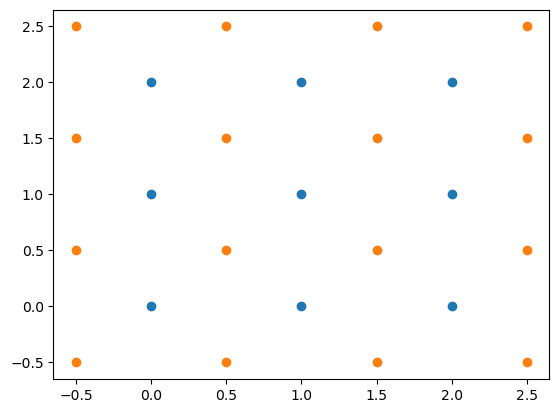

In [59]:
X_train = lattice(0, 3, 1, dim=2)
X_test = lattice(-0.5, 3.5, 1, dim=2)
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
oosf = OOSFermatKDE(alpha=1, bandwidth=2).fit(X_train)

In [60]:
oosf._dist_to_edge(X_test).min(axis=1)

array([0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678, 0.70710678, 0.70710678, 0.70710678, 0.70710678,
       0.70710678])

In [61]:
isfermat = FermatKDE(alpha=1, bandwidth=2).fit(X_train)
oosfermat = OOSFermatKDE(alpha=1, bandwidth=2).fit(X_train)
refkde = PicoKDE(bandwidth=2).fit(X_train)

In [62]:
# OOSFermat matchea in-sample Fermat cuando X_test == X_train
assert np.all(oosfermat.density(oosfermat.X_) == isfermat.density())
# OOSFermat matchea PicoKDE cuando alfa = 1
assert np.all(oosfermat.density(X_test) == refkde.density(X_test))

In [63]:
OOSFermatKDE.predict = OOSFermatKDE.density  # Parche

X = load_iris(return_X_y=True)[0][:, [0, 1]] # Keep first two columns of X only
# `Fermat` no lidia bien con distancias entre puntos repetidos
# Add random gaussian noise to X to avoid issues with repeated points
X += np.random.normal(0, 0.0001, size=X.shape)
# X = make_moons(n_samples=1000, noise=0.1)[0]

n, dim = X.shape
bw = 0.27
iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
    "OOSFermat (alpha=1)": OOSFermatKDE(alpha=1, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.25)": OOSFermatKDE(alpha=1.25, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.5)": OOSFermatKDE(alpha=1.5, bandwidth=bw).fit(X),
    "OOSFermat (alpha=2)": OOSFermatKDE(alpha=2, bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
iris_results.extend(
    {
        "dim": dim,
        "method": name,
        "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


150 2 [5.09997486 3.49983936]


In [64]:
xs = np.linspace(X[:, 0].min() * 0.95, X[:, 0].max() * 1.05, 30)
ys = np.linspace(X[:, 1].min() * 0.95, X[:, 1].max() * 1.05, 30)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


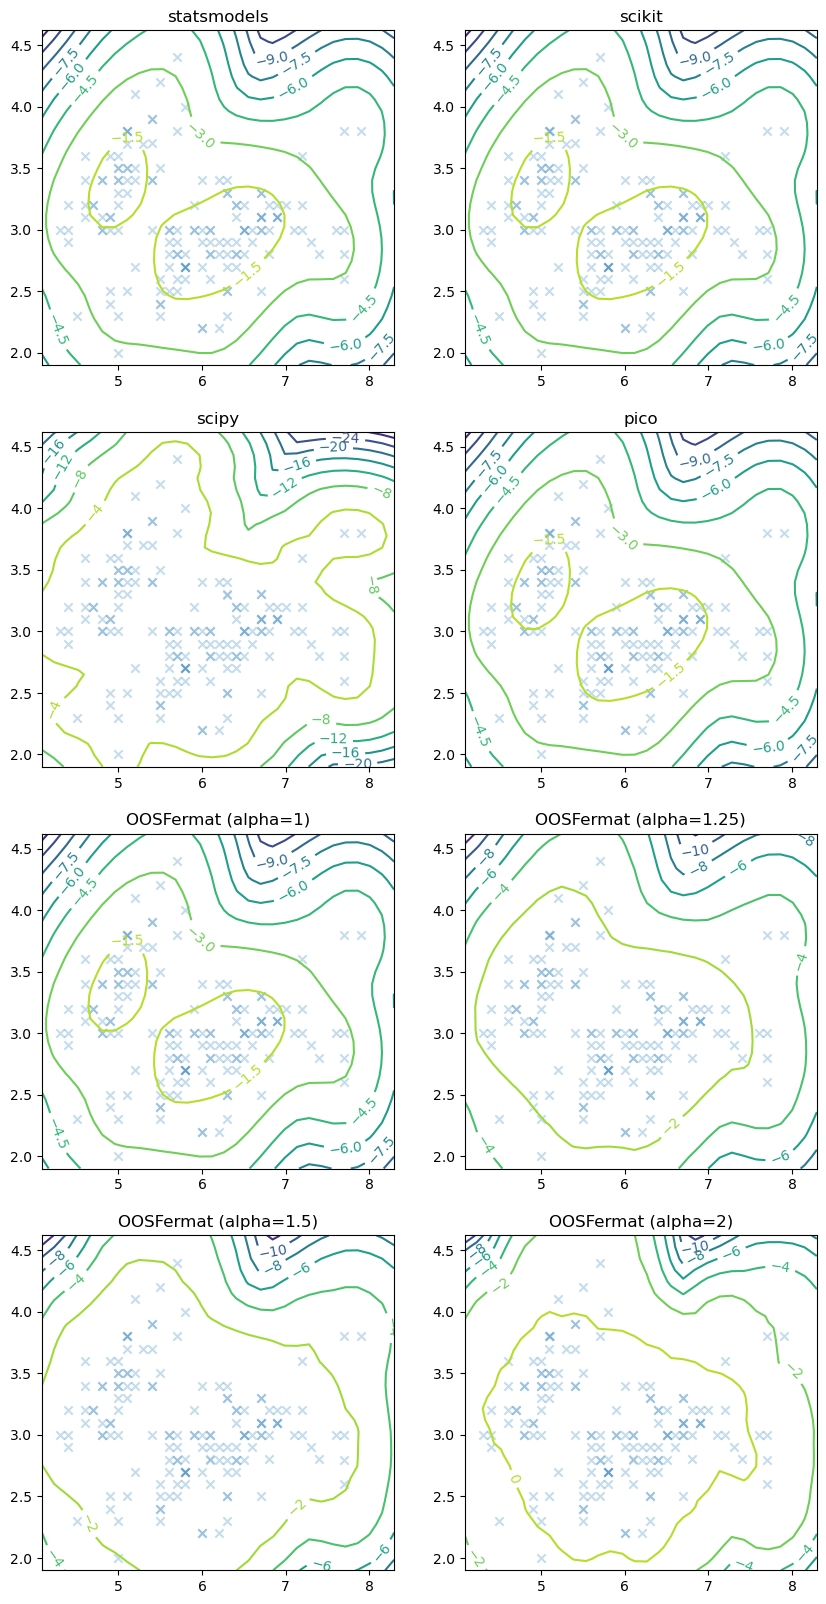

In [65]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(iris_results).iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(row.method)  # Add title to each panel
plt.show()


## Moons

In [66]:
X, y = make_moons(n_samples=1000, noise=0.1)
X = X[y==0]  # Keep only one moon

n, dim = X.shape
bw = 0.27
iris_results = []
print(n, dim, X[0])
estimators = {
    "statsmodels": KDEMultivariate(data=X, var_type="c" * dim, bw=[bw] * dim),
    "scikit": KernelDensity(bandwidth=bw).fit(X),
    "scipy": gaussian_kde(X.T, bw_method=bw),
    "pico": PicoKDE(bandwidth=bw).fit(X),
    "OOSFermat (alpha=1)": OOSFermatKDE(alpha=1, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.25)": OOSFermatKDE(alpha=1.25, bandwidth=bw).fit(X),
    "OOSFermat (alpha=1.5)": OOSFermatKDE(alpha=1.5, bandwidth=bw).fit(X),
    "OOSFermat (alpha=2)": OOSFermatKDE(alpha=2, bandwidth=bw).fit(X),
}
log_dens = {k: est.predict(X).round(3) for k, est in estimators.items()}
iris_results.extend(
    {
        "dim": dim,
        "method": name,
        "p": sum(np.exp(logd) * (step**dim)),
        "logd": logd,
    }
    for name, logd in log_dens.items()
)


500 2 [0.94921237 0.26959462]


In [67]:
xs = np.linspace(X[:, 0].min() * 0.8, X[:, 0].max() * 1.2, 30)
ys = np.linspace(X[:, 1].min() * 0.8, X[:, 1].max() * 1.2, 30)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


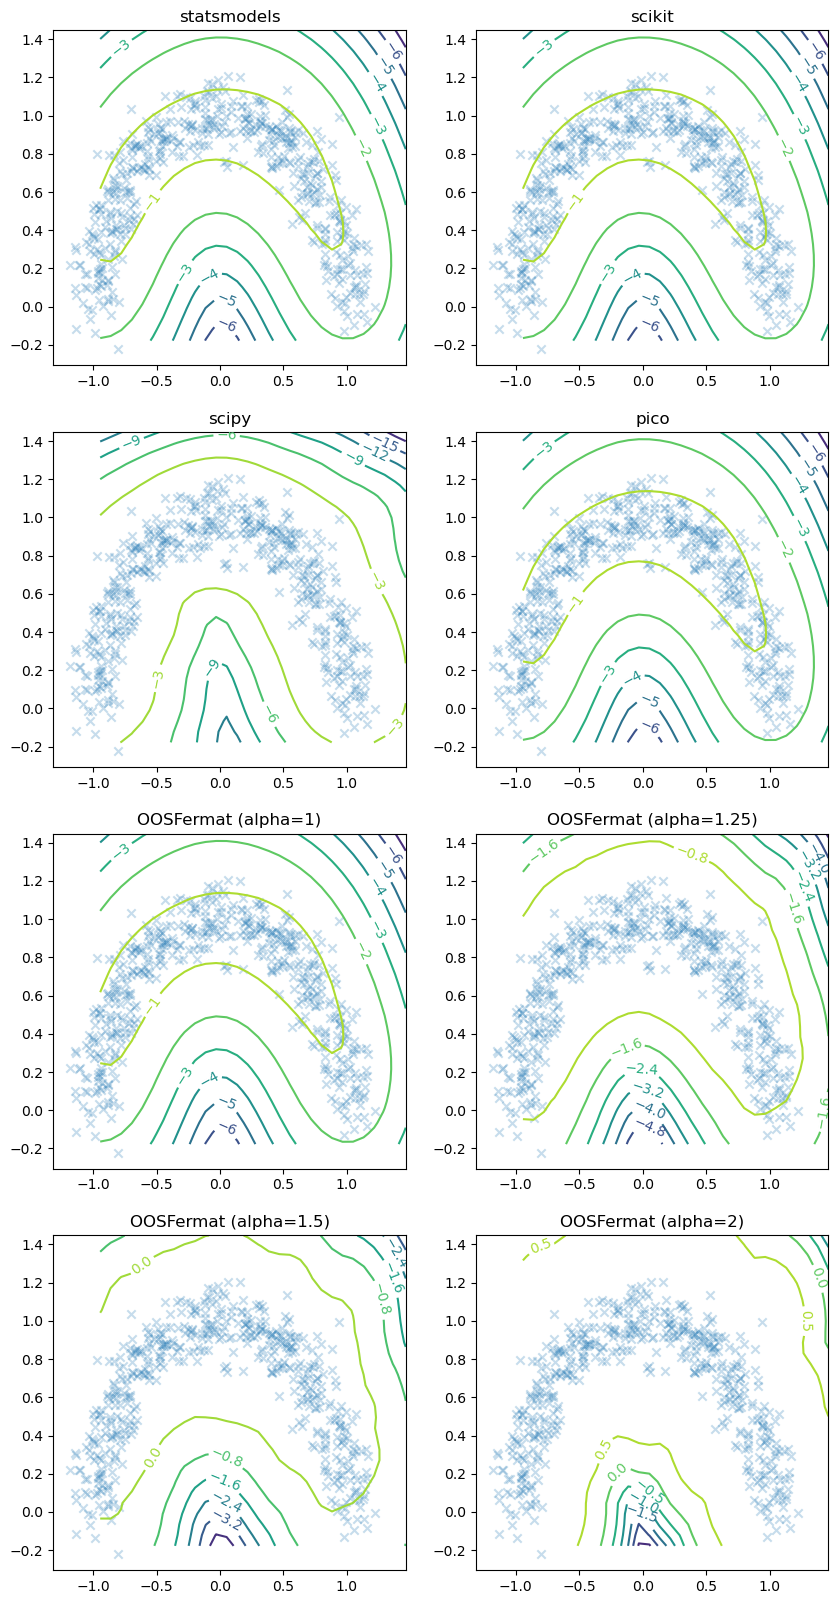

In [68]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
npoints = len(segment)
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(iris_results).iterrows():
    ax = axes[idx // 2, idx % 2]
    zz = estimators[row.method].predict(X_test).reshape(len(xx), len(yy))
    # zz = np.exp(zz) / np.exp(zz).sum()  # Normalize
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(row.method)  # Add title to each panel
plt.show()


In [69]:
pd.DataFrame(iris_results)

dim                  method          p  \
0    2             statsmodels   2.783854   
1    2                  scikit   2.783854   
2    2                   scipy   4.435122   
3    2                    pico   2.783854   
4    2     OOSFermat (alpha=1)   2.783854   
5    2  OOSFermat (alpha=1.25)   5.557935   
6    2   OOSFermat (alpha=1.5)  10.092005   
7    2     OOSFermat (alpha=2)  15.284363   

                                                logd  
0  [-1.026, -0.868, -0.789, -0.914, -0.788, -1.00...  
1  [-1.026, -0.868, -0.789, -0.914, -0.788, -1.00...  
2  [-0.57, -0.59, -0.075, -0.404, -0.119, -0.591,...  
3  [-1.026, -0.868, -0.789, -0.914, -0.788, -1.00...  
4  [-1.026, -0.868, -0.789, -0.914, -0.788, -1.00...  
5  [-0.487, -0.202, -0.069, -0.145, -0.093, -0.41...  
6  [0.144, 0.364, 0.493, 0.468, 0.461, 0.2, 0.457...  
7  [0.738, 0.757, 0.766, 0.765, 0.764, 0.744, 0.7...

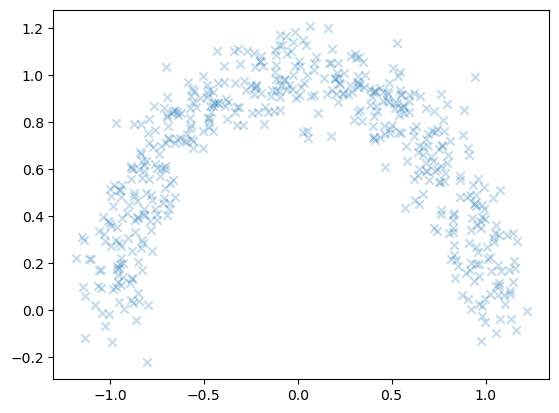

In [70]:
plt.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)

In [71]:
euclidean(X[:5]).round(3)

array([[0.   , 0.379, 1.007, 1.34 , 0.744],
       [0.379, 0.   , 0.631, 0.971, 0.37 ],
       [1.007, 0.631, 0.   , 0.357, 0.316],
       [1.34 , 0.971, 0.357, 0.   , 0.673],
       [0.744, 0.37 , 0.316, 0.673, 0.   ]])

In [72]:
%%timeit
KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func": scalar_euclidean}).fit(X)

5.5 ms ± 407 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [73]:
%%timeit
KernelDensity(bandwidth=0.27).fit(X)

85.5 µs ± 4.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [74]:
custom = KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func": scalar_euclidean}).fit(X)
standard = KernelDensity(bandwidth=0.27).fit(X)

In [75]:
%%timeit
custom.score_samples(X)

717 ms ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
%%timeit
standard.score_samples(X)

9.36 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [77]:
assert np.allclose(custom.score_samples(X), standard.score_samples(X))

In [99]:
from scipy.spatial.distance import cdist


def find_row_index(X, y):
    rows_equal = np.all(X == y, axis=1)
    return np.argmax(rows_equal) if np.any(rows_equal) else -1


class FermatDistance:
    def __init__(self, X, **kwargs):
        self.alpha = kwargs.setdefault("alpha", 1)
        self.path_method = kwargs.setdefault("path_method", "FW")
        self.X = X
        self.sample_dists = Fermat(**kwargs).fit(euclidean(self.X)).get_distances()

    def __call__(self, x, y):
        # print(f"x: {x.round(3)} | y: {y.round(3)}")
        if np.allclose(x, y):
            # print("x == y")
            return 0
        # x_dists = euclidean([x], self.X)
        # min_ix = np.argmin(x_dists)
        # print(f"Closest point to x in X: {self.X[min_ix]} ({min_ix}th row)")
        # y_dists = euclidean([y], self.X)
        # min_iy = np.argmin(y_dists)
        # print(f"Closest point to x in X: {self.X[min_iy]} ({min_iy}th row)")
        ix, iy = find_row_index(self.X, x), find_row_index(self.X, y)
        if ix >= 0:  # x in X
            if iy >= 0:  # y in X
                # print("Both in X")
                return self.sample_dists[ix, iy]
            else:
                # print("x in X, y not in X")
                return self.half_distance(y, ix)
        else:  # x not in X
            if iy >= 0:  # y in X
                # print("y in X, x not in X")
                return self.half_distance(x, iy)
            else:  # y not in X
                # print("Neither in X")
                direct_dist = power_euclidean([x], [y], p=self.alpha)[0, 0]
                through_dist = self.full_distance(x, y)
                if direct_dist < through_dist:
                    # print("Direct distance is shorter")
                    return direct_dist
                else:
                    # print("Through distance is shorter")
                    return through_dist

    def half_distance(self, x, X_index):
        # Computar euclidea a la alfa desde x a todos los puntos de X
        to_X = power_euclidean([x], self.X, p=self.alpha)
        between_X = self.sample_dists[X_index]
        return np.min(to_X + between_X)

    def full_distance(self, x, y):
        # Computar euclidea a la alfa desde x a todos los puntos de X
        to_X = power_euclidean([x], self.X, p=self.alpha)
        # Computar euclidea a la alfa desde y a todos los puntos de X
        from_X = power_euclidean([y], self.X, p=self.alpha)
        return np.min(to_X + from_X)

    def _distances(self, X_from):
        to_edge = self._dist_to_edge(X_from)
        dists = np.zeros((X_from.shape[0], self.n_))
        for i, x_from in enumerate(X_from):
            dists[i, :] = np.min(to_edge[i].T + self.fermat_dists_, axis=1)
        return dists


In [100]:
alpha = 2
fdist = FermatDistance(X, alpha=alpha)

In [101]:
X[0]

array([0.94921237, 0.26959462])

In [102]:
fdist(X[0], X[1]), fdist.sample_dists[0, 1]

(0.028763191569733802, 0.028763191569733802)

In [103]:
zero = np.zeros_like(X[0])
fdist(X[0], zero)

0.5514862721039174

In [104]:
fdist(zero, X[0])

0.5514862721039174

In [105]:
fdist(zero, zero), 0

(0, 0)

In [106]:
epsilon = 1e-6 * np.ones_like(X[0])

In [107]:
fdist(zero, epsilon), power_euclidean([zero], [epsilon], p=alpha)[0, 0]

(1.9999999999999996e-12, 1.9999999999999996e-12)

In [108]:
ten = 10 * np.ones_like(zero)
fdist(zero, ten), power_euclidean([zero], [ten], p=alpha)[0, 0]

(165.06184183701964, 200.00000000000003)

In [109]:
fdist.X[:3], X[:3]

(array([[0.94921237, 0.26959462],
        [0.7003047 , 0.55494254],
        [0.22218612, 0.96688634]]),
 array([[0.94921237, 0.26959462],
        [0.7003047 , 0.55494254],
        [0.22218612, 0.96688634]]))

In [110]:
alpha = 2
fdist = FermatDistance(X, alpha=alpha)
kdfkde = KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func":fdist}).fit(X)

In [111]:
iskde = FermatKDE(bandwidth=0.27, alpha=alpha).fit(X)
ooskde = OOSFermatKDE(bandwidth=0.27, alpha=alpha).fit(X)

In [112]:
X.mean(axis=0)

array([0.00455409, 0.62879256])

In [121]:
%%timeit
kdfkde.score_samples(X)

11.5 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [113]:
custom = kdfkde.score_samples(X)
isstandard = iskde.density()
oosstandard = ooskde.density(X)

In [114]:
np.allclose(custom, isstandard)

True

In [115]:
np.allclose(custom, oosstandard)

True

In [ ]:
kdfkde = KernelDensity(bandwidth=0.27, metric="pyfunc", metric_params={"func":FermatDistance(X, alpha=alpha)}).fit(X)

In [133]:
from time import time

X, y = make_moons(n_samples=1000, noise=0.1)
X = X[y == 0]  # Keep only one moon

methods = {
    "KD Custom Distance": lambda bw, alpha, X: KernelDensity(
        bandwidth=bw,
        metric="pyfunc",
        metric_params={"func": FermatDistance(X, alpha=alpha)},
    ).fit(X),
    "OOSFermat": lambda bw, alpha, X: OOSFermatKDE(alpha=alpha, bandwidth=bw).fit(X),
}
n, dim = X.shape
bw = 0.27
moon_results = []
print(n, dim, X[0])
estimators = {}
for alpha in [1, 1.25, 1.5, 2]:
    print(f"alpha={alpha}")
    for method, factory in methods.items():
        print(f"method={method}")
        t0 = time()
        est = factory(bw, alpha, X)
        fit_time = time() - t0
        t0 = time()
        log_dens = est.predict(X)
        pred_time = time() - t0
        moon_results.append(
            {
                "est": est,
                "method": method,
                "alpha": alpha,
                "bw": bw,
                "n": n,
                "fit_time": fit_time,
                "pred_time": pred_time,
                "dim": dim,
                "p": sum(np.exp(log_dens) * (step**dim)),
                "logd": log_dens,
            }
        )


500 2 [-0.65286243  0.38581481]
alpha=1
method=KD Custom Distance
method=OOSFermat
alpha=1.25
method=KD Custom Distance
method=OOSFermat
alpha=1.5
method=KD Custom Distance
method=OOSFermat
alpha=2
method=KD Custom Distance
method=OOSFermat


In [134]:
xs = np.linspace(X[:, 0].min() * 0.8, X[:, 0].max() * 1.2, 30)
ys = np.linspace(X[:, 1].min() * 0.8, X[:, 1].max() * 1.2, 30)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


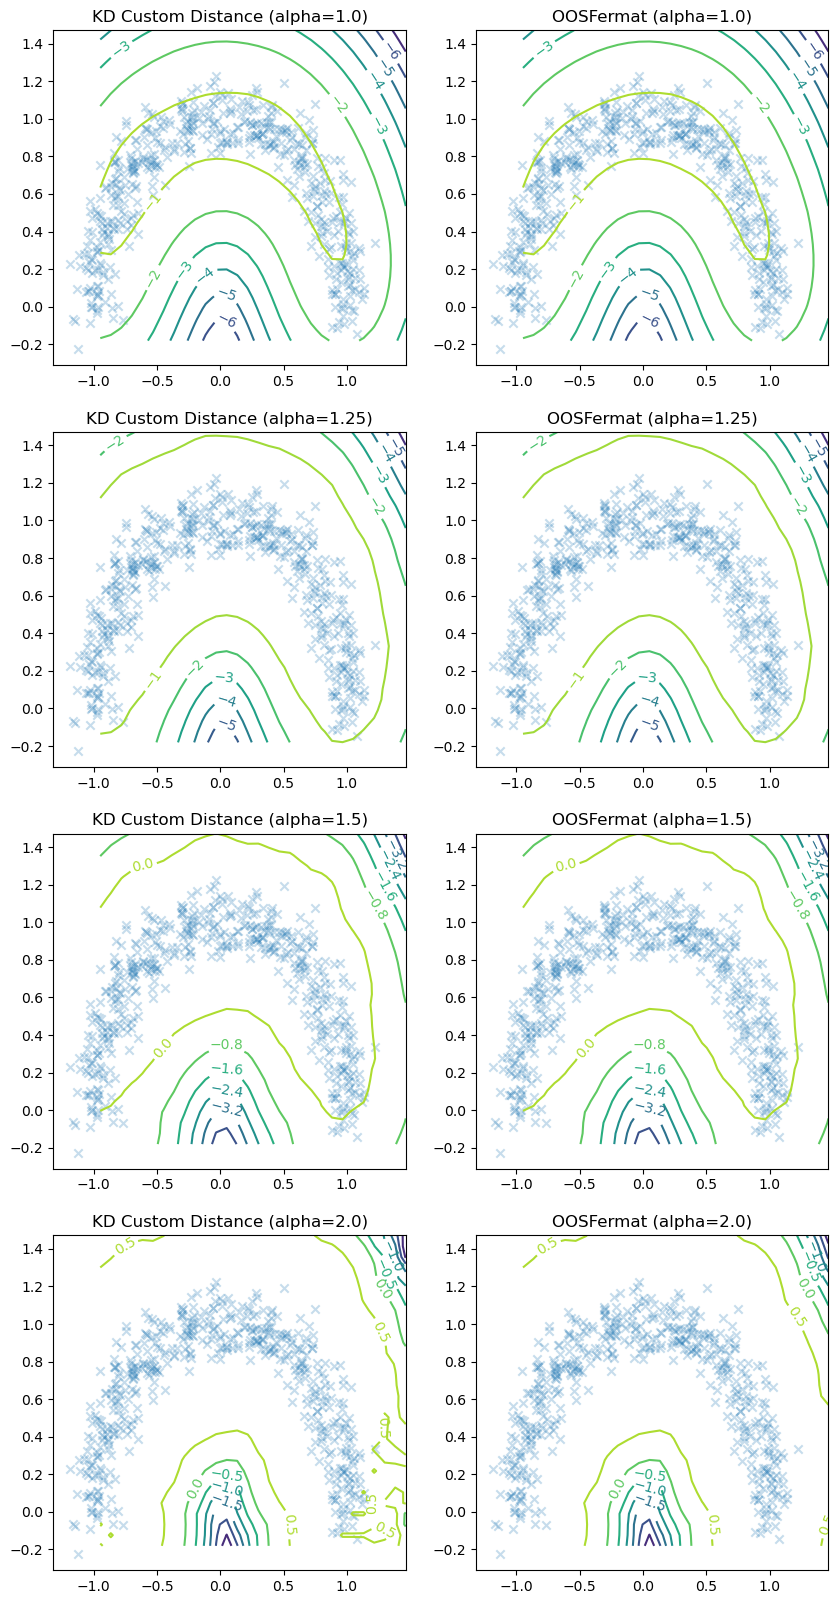

In [138]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(moon_results).iterrows():
    # print(row)
    ax = axes[idx // 2, idx % 2]
    zz = row.est.predict(X_test).reshape(len(xx), len(yy))
    # zz = np.exp(zz) / np.exp(zz).sum()  # Normalize
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (alpha={row.alpha})")  # Add title to each panel
plt.show()


In [142]:
df = pd.DataFrame(moon_results)
df["score"] = df.logd.transform(np.product)
df[["method", "alpha", "fit_time", "pred_time","n", "p", "score"]]

method  alpha  fit_time  pred_time    n          p  \
0  KD Custom Distance   1.00  0.245154   9.911299  500   2.731948   
1           OOSFermat   1.00  0.136004   0.427023  500   2.731948   
2  KD Custom Distance   1.25  0.253750  10.000806  500   5.464881   
3           OOSFermat   1.25  0.150126   0.405813  500   5.464881   
4  KD Custom Distance   1.50  0.242809   9.819888  500   9.969894   
5           OOSFermat   1.50  0.147340   0.400435  500   9.969894   
6  KD Custom Distance   2.00  0.233428   9.749768  500  15.255403   
7           OOSFermat   2.00  0.144730   0.400372  500  15.255403   

           score  
0   2.642376e-07  
1   2.642376e-07  
2  2.020987e-315  
3  2.020987e-315  
4  9.076066e-303  
5  9.076066e-303  
6   5.198849e-63  
7   5.198849e-63

## Espiral

In [144]:
import cmath

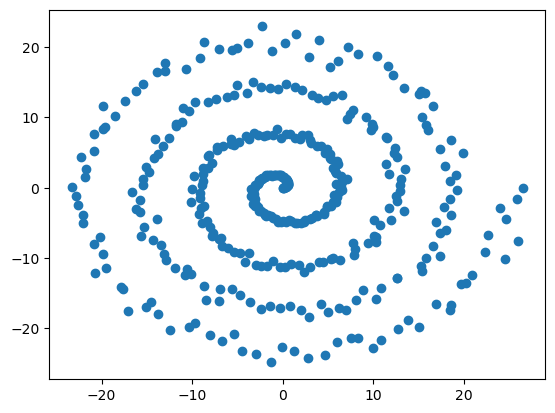

In [169]:
vueltas = 4
n = 400

muestra = np.linspace(0, 2 * np.pi * vueltas, n)
Z = [cmath.rect(x, x) for x in muestra]
X = np.array([[z.real, z.imag] for z in Z])
X *= 1 + np.random.normal(0, 0.05, size=X.shape)

plt.scatter(X[:, 0], X[:, 1])

In [170]:
methods = {
    "KD Custom Distance": lambda bw, alpha, X: KernelDensity(
        bandwidth=bw,
        metric="pyfunc",
        metric_params={"func": FermatDistance(X, alpha=alpha)},
    ).fit(X),
    "OOSFermat": lambda bw, alpha, X: OOSFermatKDE(alpha=alpha, bandwidth=bw).fit(X),
}
n, dim = X.shape
bw = 0.27
moon_results = []
print(n, dim, X[0])
estimators = {}
for alpha in [1, 1.25, 1.5, 2]:
    print(f"alpha={alpha}")
    for method, factory in methods.items():
        print(f"method={method}")
        t0 = time()
        est = factory(bw, alpha, X)
        fit_time = time() - t0
        t0 = time()
        log_dens = est.predict(X)
        pred_time = time() - t0
        moon_results.append(
            {
                "est": est,
                "method": method,
                "alpha": alpha,
                "bw": bw,
                "n": n,
                "fit_time": fit_time,
                "pred_time": pred_time,
                "dim": dim,
                "p": sum(np.exp(log_dens) * (step**dim)),
                "logd": log_dens,
            }
        )


400 2 [0. 0.]
alpha=1
method=KD Custom Distance
method=OOSFermat
alpha=1.25
method=KD Custom Distance
method=OOSFermat
alpha=1.5
method=KD Custom Distance
method=OOSFermat
alpha=2
method=KD Custom Distance
method=OOSFermat


In [171]:
xs = np.linspace(X[:, 0].min() * 0.8, X[:, 0].max() * 1.2, 30)
ys = np.linspace(X[:, 1].min() * 0.8, X[:, 1].max() * 1.2, 30)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


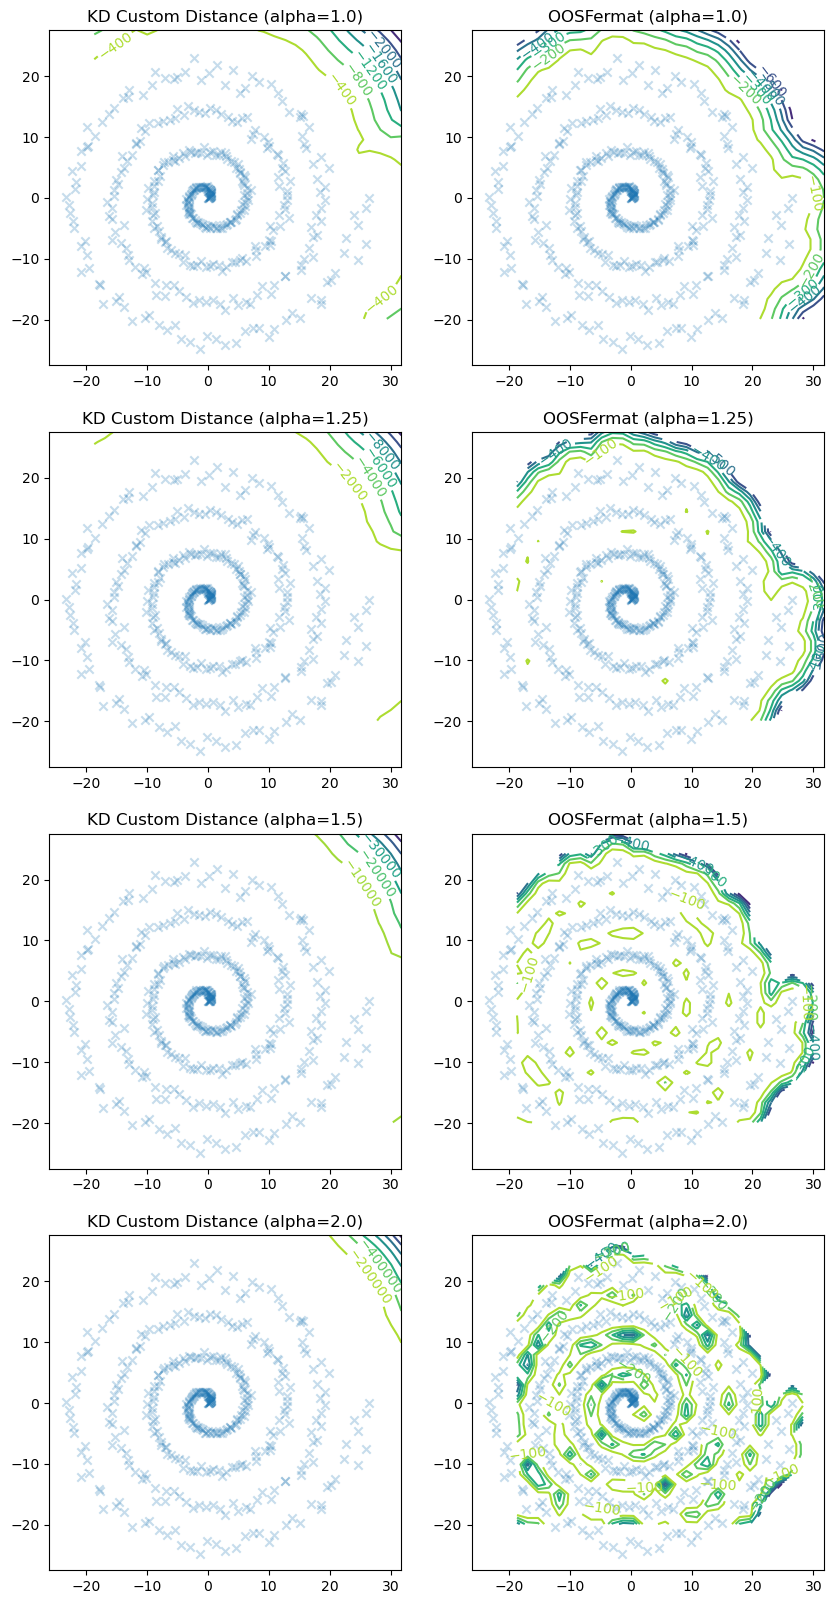

In [172]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(moon_results).iterrows():
    # print(row)
    ax = axes[idx // 2, idx % 2]
    zz = row.est.predict(X_test).reshape(len(xx), len(yy))
    # zz = np.exp(zz) / np.exp(zz).sum()  # Normalize
    cs = ax.contour(xx, yy, zz)
    ax.clabel(cs, inline=True)
    ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    ax.set_title(f"{row.method} (alpha={row.alpha})")  # Add title to each panel
plt.show()


In [173]:
df = pd.DataFrame(moon_results)
df["score"] = df.logd.transform(np.product)
df[["method", "alpha", "fit_time", "pred_time","n", "p", "score"]]

method  alpha  fit_time  pred_time    n         p  \
0  KD Custom Distance   1.00  0.146630   3.982505  400  0.057816   
1           OOSFermat   1.00  0.068545   0.264316  400  0.057816   
2  KD Custom Distance   1.25  0.147362   4.070074  400  0.071848   
3           OOSFermat   1.25  0.074673   0.252334  400  0.071848   
4  KD Custom Distance   1.50  0.144907   3.985124  400  0.090945   
5           OOSFermat   1.50  0.076548   0.265009  400  0.090945   
6  KD Custom Distance   2.00  0.142619   3.985258  400  0.139886   
7           OOSFermat   2.00  0.077285   0.258452  400  0.139886   

           score  
0  3.610075e+272  
1  3.610075e+272  
2  1.789583e+268  
3  1.789583e+268  
4  3.863549e+263  
5  3.863549e+263  
6  1.535494e+254  
7  1.535494e+254

In [186]:
xs = np.linspace(X[:, 0].min() * 0.8, X[:, 0].max() * 1.2, 100)
ys = np.linspace(X[:, 1].min() * 0.8, X[:, 1].max() * 1.2, 100)
xx, yy = np.meshgrid(xs, ys)
X_test = np.array(list(zip(xx.ravel(), yy.ravel())))


In [187]:
df = pd.DataFrame(moon_results)

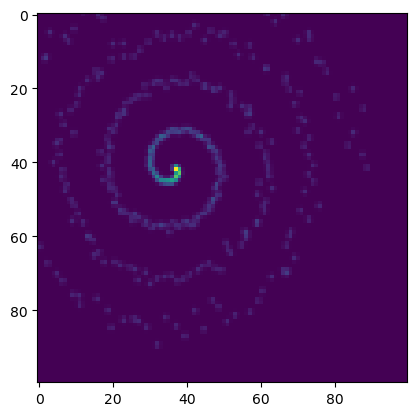

In [189]:
plt.imshow(np.exp(df.iloc[0].est.predict(X_test).reshape(len(xx), len(yy))))

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


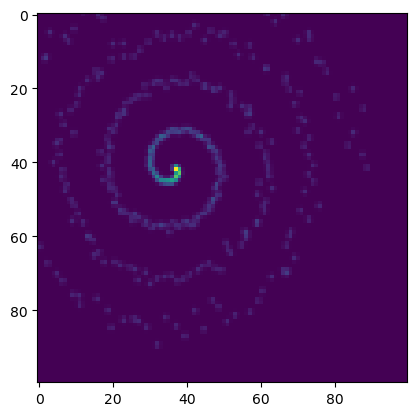

In [ ]:
plt.imshow(np.exp(df.iloc[1].est.predict(X_test).reshape(len(xx), len(yy))))

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities
/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_40405/3944994136.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


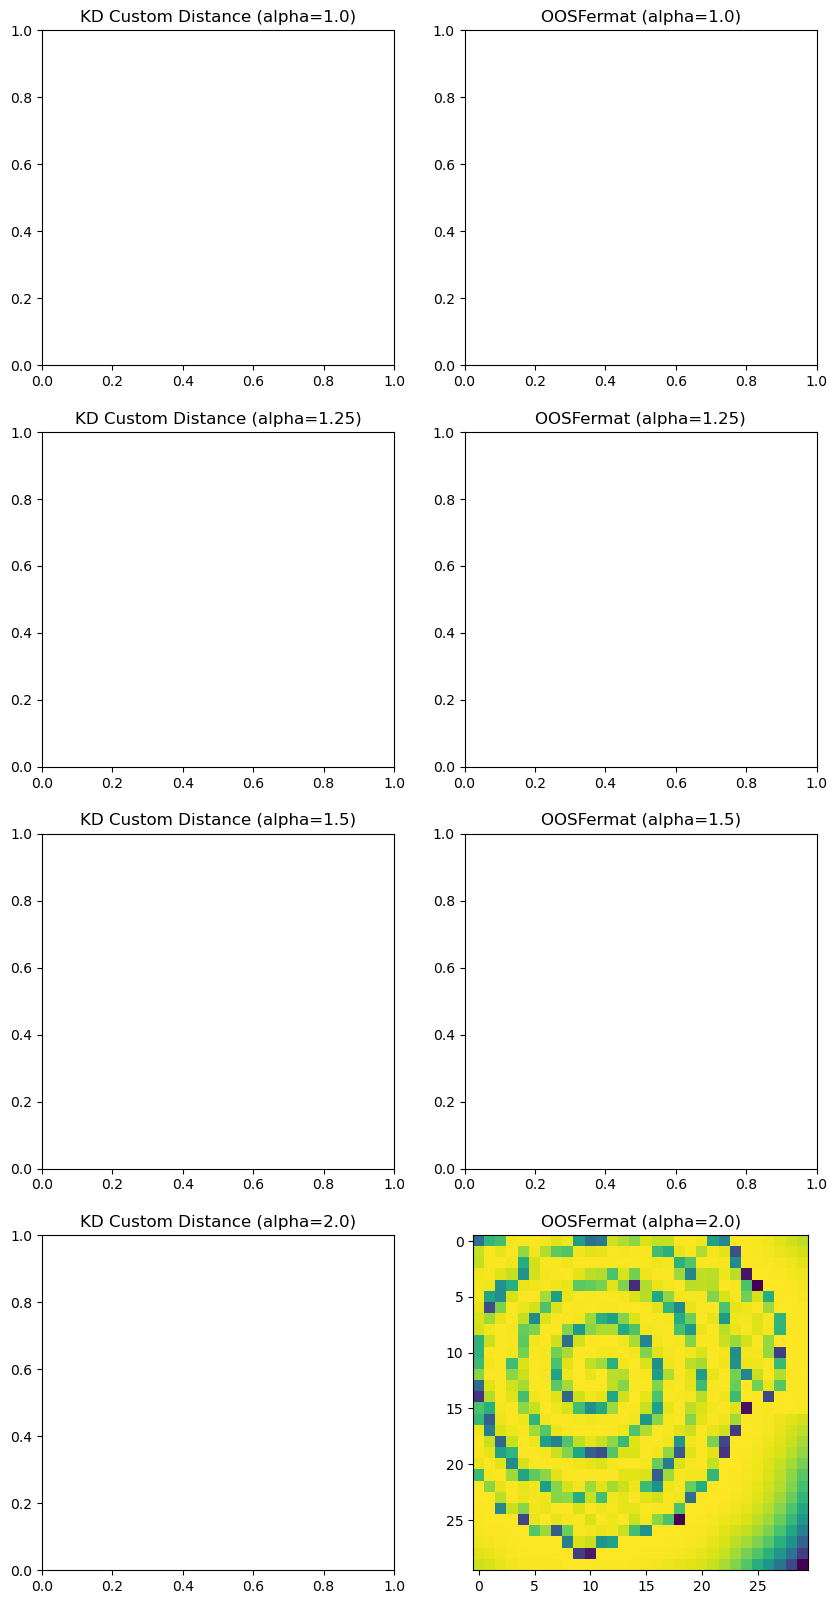

In [175]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))
# In each panel, draw a contour plot of the estimated density, using the same scale for all panels
for idx, row in pd.DataFrame(moon_results).iterrows():
    # print(row)
    ax = axes[idx // 2, idx % 2]
    zz = row.est.predict(X_test).reshape(len(xx), len(yy))
    # zz = np.exp(zz) / np.exp(zz).sum()  # Normalize
    # cs = ax.contour(xx, yy, zz)
    # ax.clabel(cs, inline=True)
    # ax.scatter(X[:, 0], X[:, 1], marker='x', alpha=0.25)
    plt.imshow(zz)
    ax.set_title(f"{row.method} (alpha={row.alpha})")  # Add title to each panel
plt.show()


## Old version

In [486]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [494]:
from sklearn.datasets import load_digits
# import GridSearch
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = grid.cv_results_["mean_test_score"]

{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


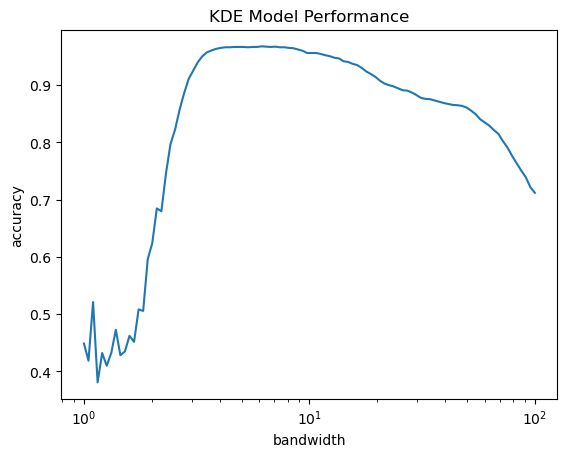

In [495]:
plt.semilogx(bandwidths, scores)
plt.xlabel("bandwidth")
plt.ylabel("accuracy")
plt.title("KDE Model Performance")
print(grid.best_params_)
print("accuracy =", grid.best_score_)


In [496]:
grid.best_estimator_

KDEClassifier(bandwidth=6.135907273413174)

In [ ]:
sns.scatterplot(x="n_dim", y="time", data=res)
est = LinearRegression().fit(res[["n_dim"]], res.time)
plt.title(f"time[s] = {est.intercept_.round(3)} + {est.coef_[0].round(3)} * n_dim")
plt.axline([0, est.intercept_], slope=est.coef_, linestyle="dashed", color="gray")
plt.show()


OK, también parece lineal en `n_dim`.

Los tiempos de `KernelDensity` son como la mitad de los de EuclideanKDE, pero no sé cuánto mejor/peor serían si implementase una DistanceMetric nueva para la distancia de Fermat. Por el momento, seguimos con la programacion habitual, y mantenemos los clasificadores de juguete.

In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
from numpy import random as rnd
import seaborn as sns


In [ ]:
A = rnd.rand(100, 3)
A.sort(axis=1)
A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
a = A[0]
a, A[
    :5,
]


In [ ]:
def fermat_dist(x, alpha=1):
    """Fermat alpha-distance between `x_0` and `x_k`, in the line graph with nodes at `x = (x_1, ..., x_k)`."""
    return ((x[1:] - x[:-1]) ** alpha).sum()


In [ ]:
np.apply_along_axis(fermat_dist, axis=1, arr=X, alpha=3).mean()


In [ ]:
sample_size = 1000
scales = [1 / 10, 1 / 2, 1, 2, 10]
alphas = np.linspace(1, 4, 7)
ks = [1, 2, 5, 10]
results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for scale in scales:
        for alpha in alphas:
            results.append(
                dict(
                    k=k,
                    alpha=alpha,
                    scale=scale,
                    dists=np.apply_along_axis(
                        fermat_dist, axis=1, arr=scale * A, alpha=alpha
                    ),
                )
            )


In [ ]:
df = pd.DataFrame(results)


In [ ]:
df["mean_dist"] = df.dists.apply(np.mean)
df["scaled_dist"] = df.mean_dist / (df.scale**df.alpha)


In [ ]:
df.head()


In [ ]:
df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)


In [ ]:
df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)


Está claro que si $c$ es la constance de escale `scale`, las distancias de fermat escalan según $c^{-\alpha}$. Ahora, cuánto cambian con el tamaño de muestra $k$? 

Para $k=1$, se puede calcular exactamente la esperanza de la longitud del camino. Si hay un único punto entre 0 y 1 elegido al azar según $X \sim \text{Unif}(0, 1)$, entonces la longitud del camino de Fermat cuando $alpha=2$ será $E\left(X^2 + (1-X)^2\right) = 2/3$, lo cual se ve en la tabla anterior. Para $k=1$ y otros valores de $\alpha$, la expresión no será tan bella pero es computable sin mucha dificultad. Para otros valores de $k$, sin embargo, ya entran en juego la distribución de los estadísticos de orden y no me resulta para nada evidente una fórmula cerrada.

Aproximémosla. Sean $X^{(0)} = 0, X^{(k+1)} = 1$ y $X^{(i)}, i=1,\dots,k$ las v.a. que surgen de ordenar una muestra $X_i \sim_{iid} \text{Unif}(0, 1), \ i\in[k]$. Para todo $k$ se cumple que cada "segmentito de recta", $\mathbb{E}\left(X^{(i+1)}-X^{(i)}\right) = 1 / (k + 1)$. Luego, esperaríamos que 

$$
\begin{align} dist_{\alpha}^k(0, 1) &= \mathbb{E}\ \left(\sum_{i=0}^k \left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &=  \sum_{i=0}^k\ \left( \mathbb{E}\left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &\approx (???) (k + 1) \left(\frac{1}{k+1}\right)^{\alpha}
   \end{align}

$$

Pero no vale que $E(X^k) = E(X)^k$! Qué se hace en su lugar? Hay que conocer la densidad de $X^{(i+1)}-X^{(i)}$ y calcularlo? Empíricamente, veamos como cambia la distancia con $k$.

In [ ]:
df[df.scale == 1].pivot("alpha", "k", "scaled_dist")


In [ ]:
df["k_scaled_dist"] = df.scaled_dist * ((df.k + 2) ** (df.alpha - 1))
df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")


In [ ]:
df


In [ ]:
sample_size = 1000
alphas = [1.5, 1.75, 2, 2.25, 3, 4, 5]
ks = np.array([*range(1, 11), *rnd.choice(range(11, 2001), 50, replace=False)])

results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for alpha in alphas:
        results.append(
            dict(
                k=k,
                alpha=alpha,
                dists=np.apply_along_axis(fermat_dist, axis=1, arr=A, alpha=alpha),
            )
        )

df = pd.DataFrame(results)
df["mean_dist"] = df.dists.apply(np.mean)


In [ ]:
df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)


In [ ]:
plt.figure(figsize=(16, 7))
sns.lineplot(x="k", y="mean_dist", hue="alpha", data=df, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.show()


Para la elección del ancho de banda $h$ es necesario saber la escala de las distancias! Con qué se come esto???

In [ ]:
results = []
for i in range(10000):
    s = rnd.rand(100)
    s.sort()
    dists = (np.array([s[0], *(s[1:] - s[:-1]), 1 - s[-1]])) ** 2
    results.append((dists.mean(), dists.std()))


In [ ]:
np.mean([std / mean for mean, std in results])


## Implementación KDEClassifier

In [ ]:
from scipy.stats import norm
from numpy.linalg import norm as euclidean_norm
from scipy.spatial import distance_matrix


In [ ]:
import scipy

scipy.spatial.distance.minkowski(A[0], A[2])


In [ ]:
B = range(5)
C = range(7)
[[b * c for c in C] for b in B]


In [ ]:
(A[:] == A[2]).all(1)[:5]


In [ ]:
A.shape, np.zeros(10)


In [ ]:
norm_pdf = scipy.stats.norm.pdf


class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y  # , check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [ ]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [ ]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [ ]:
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())

In [ ]:
A = np.array([[i] * 2 for i in range(3)])
Fermat(2, "FW").fit(distance_matrix(A, A)).get_distances()


In [ ]:
B = np.vstack([[-1, 0], [1, 0]])
B


In [ ]:
C = np.vstack([A, B])


In [ ]:
full = Fermat(2, "FW").fit(distance_matrix(C, C))
full_dists = full.get_distances()


In [ ]:
n_train = 120
train = FermatKDE(2, "FW").fit(A)
test_dists = train.distances(B)


In [ ]:
full_dists, test_dists


In [ ]:
full = Fermat(2, "FW").fit(distance_matrix(X, X))
full_dists = full.get_distances()


In [ ]:
n_train = 120
train = FermatKDE(2, "FW").fit(X[:n_train])
test_dists = train.distances(X[n_train:])


In [ ]:
np.where(full_dists[n_train:, :n_train] > test_dists + 0.001)


In [ ]:
full_dists[n_train:, :n_train][22, 101], test_dists[22, 101]


In [ ]:
pd.Series((full_dists[n_train:, :n_train] - test_dists).flatten()).describe()


In [ ]:
# Fermat distnaces between train obss, with X=train osbs, must be >= than
#   Fermat distances bw train obss, with X=(train obss + test obss)
assert (train.distances_ >= full_dists[:n_train, :n_train]).all()


```python
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())
```

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier


In [ ]:
plt.imshow(X[10].reshape(8, 8), cmap="gray")
y[10]


In [ ]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.80)
eucclf = EuclideanKDEClassifier(bandwith=1).fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=200).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(
    np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train
)


In [ ]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(
    repr(rfclf2),
    " - enhanced: ",
    accuracy_score(
        rfclf2.predict(
            np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)
        ),
        y_test,
    ),
)


In [ ]:
accuracy_score(eucclf.predict(X_test), y_test), accuracy_score(
    fmtclf.predict(X_test), y_test
)


In [ ]:
X_digits, y_digits = load_digits(return_X_y=True)
n, d = X_digits.shape


In [ ]:
fmt = Fermat(alpha=2, path_method="FW")
euc_dists = distance_matrix(X_digits, X_digits)
fmt.fit(euc_dists / (d))
fmt_dists = fmt.get_distances()


In [ ]:
euc_dists[:5, :5] / d


In [ ]:
fmt_dists[:5, :5]


In [ ]:
[x.shape for x in [X_train, X_test, y_train, y_test]]


In [ ]:
from scipy.special import softmax as sp_softmax

D = fmtclf.decision_function(X_test)
sp_softmax(D, axis=1).round(2)[:5]


In [ ]:
(np.argmax(preds, axis=1) == y_test).mean()


In [ ]:
X, y = load_iris(return_X_y=True)
N = len(X)  # # observaciones
K = len(set(y))  # # clases


In [ ]:
kde = KDEstimator()


In [ ]:
kde.fit(X[y == 0])


In [ ]:
kde.predict(X[-1])


In [ ]:
y[0]


## TemplateClassifier

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances


class TemplateClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, demo_param="demo"):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]


In [ ]:
unique_labels()


In [ ]:
np.random.random()


In [ ]:
import math

PI = math.pi
center = (0, 0)
inner_radius, outer_radius = 1, 1.5
sigma = 0.25
n_class = 500
n = n_class * 2
angles = np.random.rand(n) * 2 * PI


In [ ]:
y = np.concatenate([np.zeros(n_class), np.ones(n_class)]).astype(int)
np.random.shuffle(y)
radii = np.where(y, outer_radius, inner_radius) + np.random.normal(scale=sigma, size=n)
X = np.array(
    [
        [radius * np.cos(angle), radius * np.sin(angle), 0, 0]
        for radius, angle in zip(radii, angles)
    ]
)


In [ ]:
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


In [ ]:
rfclf = RandomForestClassifier().fit(X_train, y_train)
accuracy_score(rfclf.predict(X_test), y_test)


In [ ]:
eucclf = EuclideanKDEClassifier(bandwith=0.3).fit(X_train, y_train)
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
fmtclf = FermatKDEClassifier(bandwith=0.2, alpha=1.2).fit(X_train, y_train)
accuracy_score(fmtclf.predict(X_test), y_test)


In [ ]:
np.logspace(-2, 1, 20)


In [ ]:
grid = dict(bandwith=np.logspace(-2, 1, 30))


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
eucclf = GridSearchCV(EuclideanKDEClassifier(), grid).fit(X_train, y_train)


In [ ]:
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
eucclf.best_estimator_


In [ ]:
grid = dict(alpha=[1.25, 1.5], bandwith=np.logspace(-2, 0, 10))


In [ ]:
fmtclf = GridSearchCV(FermatKDEClassifier(), grid)


In [ ]:
fmtclf.fit(X_train, y_train)


In [ ]:
accuracy_score(fmtclf.predict(X_test), y_test)


In [ ]:
fmtclf.best_params_


In [ ]:
accuracy_score(clf.predict(X_train), y_train), accuracy_score(
    clf.predict(X_test), y_test
)


In [ ]:
accuracy_score(rfclf.predict(X_train), y_train), accuracy_score(
    rfclf.predict(X_test), y_test
)


In [ ]:
accuracy_score(eucclf.predict(X_train), y_train), accuracy_score(
    eucclf.predict(X_test), y_test
)


In [ ]:
eucclf = GridSearchCV(
    EuclideanKDEClassifier(), {"bandwith": np.logspace(-2, 0, 20)}
).fit(X_train, y_train)
eucclf.best_params_


In [ ]:
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
X.min(axis=0), X.max(axis=0)


In [ ]:
x = np.linspace(-4, 4, 50)
y = np.linspace(-4, 4, 50)


In [ ]:
xx, yy = np.meshgrid(x, y)


In [ ]:
rcclf.predict()


In [ ]:
rfpred = rfclf.predict(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))


In [ ]:
sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=rfpred)


In [ ]:
fmtpred = clf.predict(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))


In [ ]:
sns.scatterplot(x=xx.ravel(), y=yy.ravel(), hue=rfpred)


In [ ]:
def trefoil(n, start=0, noise_dims=37, end=2 * PI):
    T = start + (end - start) * np.random.rand(n)
    X_tref = np.array(
        [[np.sin(t), np.cos(t) - 2 * np.cos(2 * t), -np.sin(3 * t)] for t in T]
    )
    X_noise = scipy.stats.norm.rvs(scale=0.05, size=(n, noise_dims))
    return np.concatenate([X_tref, X_noise], axis=1)


In [ ]:
X_trefA = trefoil(200)


In [ ]:
X_trefB = trefoil(200)


In [ ]:
X_trefB[:, [0, 1, 2]] = X_trefB[:, [1, 2, 0]]


In [ ]:
X_tref = np.concatenate([X_trefA, X_trefB], axis=0)


In [ ]:
y_tref = np.concatenate([np.zeros(200), np.ones(200)], axis=0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tref, y_tref, test_size=0.80)


In [ ]:
rfclf = RandomForestClassifier().fit(X_train, y_train)
accuracy_score(rfclf.predict(X_test), y_test)


In [ ]:
eucclf = EuclideanKDEClassifier(bandwith=0.3).fit(X_train, y_train)
accuracy_score(eucclf.predict(X_test), y_test)


In [ ]:
fmtclf = FermatKDEClassifier(bandwith=0.2, alpha=1.2).fit(X_train, y_train)
accuracy_score(fmtclf.predict(X_test), y_test)
